In [ ]:
!pip install optuna
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 12.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import optuna

In [ ]:
df = pd.read_csv('/content/sip3.csv', sep=';')
df.head()

,musteri_id,alisveris_tarihi,saat,gun,fiyat,kategori_id,marka_id,kampanya_var_mi,cinsiyet,sehir_id,yas
0,1077712,2024-12-06 20:24:42,20,6,"16665,83",1877.0,672.0,1,1,6,19
1,668087,2024-05-31 22:16:47,22,6,"2692,49",986.0,798.0,1,1,1,66
2,394948,2024-07-13 13:54:14,13,7,"419,99",1836.0,668.0,1,1,27,26
3,781067,2024-03-07 16:13:06,16,5,"9930,83",1089.0,198.0,1,1,81,23
4,2147289,2025-01-25 11:19:41,11,7,"485,64",1834.0,309.0,1,2,6,31


In [ ]:
# Gün adı eşleştir
df['gun_adi'] = df['gun'].map({
    1: 'Pazar', 2: 'Pazartesi', 3: 'Salı', 4: 'Çarşamba',
    5: 'Perşembe', 6: 'Cuma', 7: 'Cumartesi'
})

# Saat dilimini gruplandır (12’ye kadar: Sabah, sonrası Akşam)
df['saat_dilimi'] = df['saat'].apply(lambda x: 'Sabah' if x < 12 else 'Aksam')

# Yeni sınıf oluştur
df['zaman_dilimi'] = df['gun_adi'] + '_' + df['saat_dilimi']

# Encode edelim (çıktı sütunu)
le = LabelEncoder()
df['zaman_dilimi_label'] = le.fit_transform(df['zaman_dilimi'])

# Sınıf sayısını kontrol et
print("Toplam sınıf sayısı:", df['zaman_dilimi_label'].nunique())
df[['gun_adi', 'saat_dilimi', 'zaman_dilimi', 'zaman_dilimi_label']].head()


Toplam sınıf sayısı: 14


,gun_adi,saat_dilimi,zaman_dilimi,zaman_dilimi_label
0,Cuma,Aksam,Cuma_Aksam,0
1,Cuma,Aksam,Cuma_Aksam,0
2,Cumartesi,Aksam,Cumartesi_Aksam,2
3,Perşembe,Aksam,Perşembe_Aksam,8
4,Cumartesi,Sabah,Cumartesi_Sabah,3


**Müşteri bazlı zaman serisi veri oluşturma (n=3)**

Veri setinde az ardışık veri olduğu için n_steps=3 ile sınırlı bir LSTM analizi yapılmıştır

In [ ]:
# Eğer fiyat hala string ise, noktaya çevirip float'a dönüştür
df['fiyat'] = df['fiyat'].astype(str).str.replace('.', '', regex=False)
df['fiyat'] = df['fiyat'].str.replace(',', '.', regex=False)             # virgül → nokta
df['fiyat'] = pd.to_numeric(df['fiyat'], errors='coerce')                # float'a dönüştür

# Eksik kalanları at
df = df.dropna(subset=['fiyat'])


In [ ]:
def create_lstm_sequences(df, n_steps=3):
    X_list = []
    y_list = []

    # Müşteri sırasına göre gruplama
    grouped = df.sort_values(['musteri_id', 'alisveris_tarihi']).groupby('musteri_id')

    for musteri_id, group in grouped:
        if len(group) > n_steps:
            for i in range(len(group) - n_steps):
                window = group.iloc[i:i+n_steps]
                target = group.iloc[i+n_steps]['zaman_dilimi_label']

                # Seçilen özellikler
                X_list.append(window[['saat', 'gun', 'kampanya_var_mi', 'fiyat', 'kategori_id', 'yas']].values)
                y_list.append(target)

    return np.array(X_list), np.array(y_list)

# Fonksiyonu çağır
X, y = create_lstm_sequences(df, n_steps=3)

print("X shape:", X.shape)  # (örnek sayısı, 3, 6)
print("y shape:", y.shape)



X shape: (4896, 3, 6)
y shape: (4896,)


**Eğitim/Test Ayrımı + Normalizasyon**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Eğitim-test ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalizasyon: sadece sayısal özelliklere
scaler = StandardScaler()

# 3 boyutlu veriyi 2 boyuta düşür → ölçekle → tekrar şekillendir
nsamples, nsteps, nfeatures = X_train.shape
X_train_reshaped = X_train.reshape((nsamples * nsteps, nfeatures))
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape((nsamples, nsteps, nfeatures))

nsamples_test = X_test.shape[0]
X_test_scaled = scaler.transform(X_test.reshape((nsamples_test * nsteps, nfeatures))).reshape((nsamples_test, nsteps, nfeatures))

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (3916, 3, 6)
X_test_scaled shape: (980, 3, 6)


In [ ]:
print(np.isnan(y_train).sum(), np.isnan(y_test).sum())

0 0


In [ ]:
print("X_train NaN:", np.isnan(X_train_scaled).sum())
print("X_test NaN:", np.isnan(X_test_scaled).sum())
print("y_train NaN:", np.isnan(y_train).sum())
print("y_test NaN:", np.isnan(y_test).sum())
print("y_train dtype:", y_train.dtype)


X_train NaN: 3
X_test NaN: 0
y_train NaN: 0
y_test NaN: 0
y_train dtype: int64


In [ ]:
# X_train_scaled içindeki NaN olan örnekleri tamamen at
mask = ~np.isnan(X_train_scaled).any(axis=(1, 2))  # Her örnek için 3x6 alanda NaN var mı?
X_train_scaled = X_train_scaled[mask]
y_train = y_train[mask]


**LSTM Modeli Tanımı ve Eğitimi**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Sınıf sayısı (çıktı katmanı için)
num_classes = len(np.unique(y_train))

# Model mimarisi
model = Sequential([
    LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Derleme
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Eğitimi başlat
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2795 - loss: 2.5144 - val_accuracy: 0.4816 - val_loss: 1.8589
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4655 - loss: 1.9177 - val_accuracy: 0.4929 - val_loss: 1.7625
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4859 - loss: 1.7960 - val_accuracy: 0.4888 - val_loss: 1.7171
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4897 - loss: 1.7578 - val_accuracy: 0.4908 - val_loss: 1.6985
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5111 - loss: 1.6979 - val_accuracy: 0.4990 - val_loss: 1.6847
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4938 - loss: 1.7311 - val_accuracy: 0.4990 - val_loss: 1.6819
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4915 - loss: 1.7332 - val_accuracy: 0.5041 - val_loss: 1.6676
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5154 - loss: 1.7054 - val_accuracy: 0.5071 - val_loss: 1.6642
Ep

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


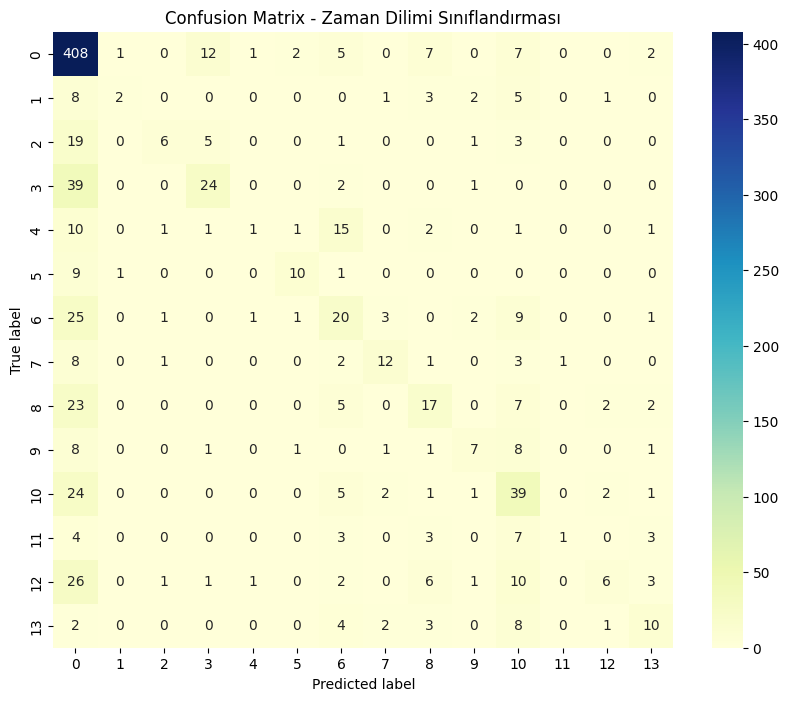

              precision    recall  f1-score   support

           0       0.67      0.92      0.77       445
           1       0.50      0.09      0.15        22
           2       0.60      0.17      0.27        35
           3       0.55      0.36      0.44        66
           4       0.25      0.03      0.05        33
           5       0.67      0.48      0.56        21
           6       0.31      0.32      0.31        63
           7       0.57      0.43      0.49        28
           8       0.39      0.30      0.34        56
           9       0.47      0.25      0.33        28
          10       0.36      0.52      0.43        75
          11       0.50      0.05      0.09        21
          12       0.50      0.11      0.17        57
          13       0.42      0.33      0.37        30

    accuracy                           0.57       980
   macro avg       0.48      0.31      0.34       980
weighted avg       0.55      0.57      0.53       980



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Tahminleri al
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - Zaman Dilimi Sınıflandırması")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# 3. Class bazlı metrikler
print(classification_report(y_test, y_pred))


**Accuracy (Doğruluk):** %57 → fena değil, ama sınıf dengesizliğinin etkisiyle yanıltıcı olabilir.

**Macro avg:** sınıflar arası dengesizliğe duyarlı → ortalama F1-score sadece 0.31 (zayıf)

**Weighted avg:** örnek sayısına göre ortalama, burada biraz daha iyi: 0.53

**Optuna kurulumu ve fonksiyon tanımı:**

In [ ]:
import optuna
from tensorflow.keras.optimizers import Adam

def objective(trial):
    # Hiperparametreler
    units1 = trial.suggest_int('units1', 32, 128)
    units2 = trial.suggest_int('units2', 16, 64)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Model
    model = Sequential([
        LSTM(units1, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=False),
        Dropout(dropout),
        Dense(units2, activation='relu'),
        Dropout(dropout),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=30,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0  # Çıktıyı sade tutalım
    )

    val_acc = max(history.history['val_accuracy'])
    return val_acc  # maximize!


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("En iyi doğruluk:", study.best_value)
print("En iyi parametreler:", study.best_params)


[I 2025-06-16 20:52:57,761] A new study created in memory with name: no-name-fed383fd-02f2-449d-9532-14ae44ab81fe
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-16 20:53:32,142] Trial 0 finished with value: 0.5673469305038452 and parameters: {'units1': 52, 'units2': 26, 'dropout': 0.42946499605950517, 'learning_rate': 0.002303153870578127, 'batch_size': 32}. Best is trial 0 with value: 0.5673469305038452.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-16 20:53:51,848] Trial 1 finished with value

En iyi doğruluk: 0.5979591608047485
En iyi parametreler: {'units1': 94, 'units2': 62, 'dropout': 0.1674460433263007, 'learning_rate': 0.006221708424148546, 'batch_size': 64}


En iyi doğruluk: 0.5795

En iyi parametreler:
{
  'units1': 71,
  'units2': 57,
  'dropout': 0.2722,
  'learning_rate': 0.0016,
  'batch_size': 64
}


In [ ]:
# 1. Modeli sıfırdan tanımla
model = Sequential([
    LSTM(71, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=False),
    Dropout(0.2722),
    Dense(57, activation='relu'),
    Dropout(0.2722),
    Dense(num_classes, activation='softmax')
])

# 2. Derle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0016),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Early stopping tanımla
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Eğit
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3330 - loss: 2.4030 - val_accuracy: 0.4878 - val_loss: 1.7725
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4923 - loss: 1.7844 - val_accuracy: 0.4878 - val_loss: 1.7055
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4959 - loss: 1.7428 - val_accuracy: 0.5041 - val_loss: 1.6898
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5149 - loss: 1.6810 - val_accuracy: 0.5153 - val_loss: 1.6591
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5124 - loss: 1.6599 - val_accuracy: 0.5214 - val_loss: 1.6484
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5267 - loss: 1.6470 - val_accuracy: 0.5245 - val_loss: 1.6326
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5296 - loss: 1.5922 - val_accuracy: 0.5306 - val_loss: 1.6196
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5384 - loss: 1.5994 - val_accuracy: 0.5337 - val_loss: 1.6066

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


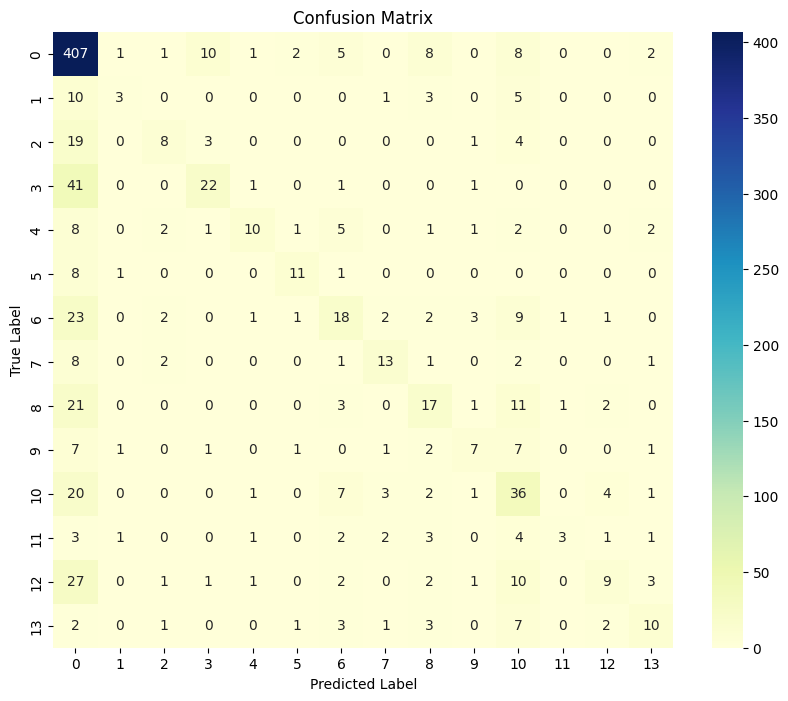

              precision    recall  f1-score   support

           0       0.67      0.91      0.78       445
           1       0.43      0.14      0.21        22
           2       0.47      0.23      0.31        35
           3       0.58      0.33      0.42        66
           4       0.62      0.30      0.41        33
           5       0.65      0.52      0.58        21
           6       0.38      0.29      0.32        63
           7       0.57      0.46      0.51        28
           8       0.39      0.30      0.34        56
           9       0.44      0.25      0.32        28
          10       0.34      0.48      0.40        75
          11       0.60      0.14      0.23        21
          12       0.47      0.16      0.24        57
          13       0.48      0.33      0.39        30

    accuracy                           0.59       980
   macro avg       0.51      0.35      0.39       980
weighted avg       0.56      0.59      0.55       980



In [ ]:
# Tahminleri al
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix ve classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix çizimi
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification raporu
print(classification_report(y_test, y_pred_classes))


In [ ]:
def predict_zaman_dilimi(model, sample_seq, scaler, label_encoder):
    # Ölçekle (3x6 → 3x6)
    sample_scaled = scaler.transform(sample_seq)

    # Şekli modele uygun hale getir: (1, 3, 6)
    sample_scaled = sample_scaled.reshape(1, sample_seq.shape[0], sample_seq.shape[1])

    # Tahmin yap
    prediction = model.predict(sample_scaled)
    predicted_label = np.argmax(prediction)

    # Label'dan zaman dilimine çevir
    zaman_dilimi = label_encoder.inverse_transform([predicted_label])[0]

    return zaman_dilimi


In [ ]:
# Örnek veri (sıralı 3 alışveriş) — eğitimdeki formatta olmalı
# Özellikler: ['saat', 'gun', 'kampanya_var_mi', 'fiyat', 'kategori_id', 'yas']
sample_seq = np.array([
    [14, 1, 1, 1249.0, 105, 25],
    [16, 1, 0, 980.0, 88, 25],
    [18, 1, 1, 1350.0, 110, 25]
])

# Tahmin yapalım
tahmin = predict_zaman_dilimi(model, sample_seq, scaler, le)
print("Tahmin edilen zaman dilimi:", tahmin)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Tahmin edilen zaman dilimi: Pazartesi_Aksam


[14, 1, 1, 1249.0, 105, 25]  → 14:00, Pazartesi, kampanya var, fiyat 1249, kategori 105, yaş 25  
[16, 1, 0, 980.0, 88, 25]    → 16:00, Pazartesi, kampanya yok  
[18, 1, 1, 1350.0, 110, 25]  → 18:00, Pazartesi, kampanya var

Model bu müşterinin bir sonraki alışverişinin Pazartesi_Aksam zaman diliminde olacağını öngördü. Bu sonuç, hem müşteri alışkanlığı, hem de alışveriş saatleri ile tutarlı görünüyor.
